In [20]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline

# Overview
The purpose of this notebook is to demonstrate the application of particle filtering to stochastic volatility modeling. The insight gained from Chapter 2, namely a **sequential** or **iterative** application of Bayes's theorem, referred to as "sequential Bayesian updates", is the foundation of real-time **Bayesian filtering**. Kalman filtering is well known example of Bayesian filtering and we begin by reviewing it here.

## Kalman filtering

### Question: the autoregressive moving average $\text{ARMA}(p, q)$ model

The **autoregressive moving average $\text{ARMA}(p, q)$** model can be written as
$$y_t = \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \eta_t + \theta_1 \eta_{t-1} + \ldots + \theta_q \eta_{t-q},$$
where $\eta_t \sim \mathcal{N}(0, \sigma^2)$, and includes as special casses all $\text{AR}(p)$ and $\text{MA}(q)$ models. Such models are often fitted to financial time series. Suppose that we would like to filter this time series using a Kalman filter. Write down suitable process and observation models.

### Solution

Set $m := \max(p, q + 1)$, $\phi_i := 0$ for $i > p$, $\theta_i := 0$ for $i > q$. Then we obtain our process model as
$$\mathbf{X}_t = \mathbf{F}_t \mathbf{X}_{t-1} + \mathbf{a}_t + \mathbf{W}_t \mathbf{w}_t,$$
and the observation model as
$$\mathbf{Y}_t = \mathbf{H}_t \mathbf{X}_t + \mathbf{b}_t + \mathbf{V}_t \mathbf{v}_t,$$
where
\begin{equation*}
\mathbf{X}_t =
\begin{pmatrix}
y_t \\
\phi_2 y_{t-1} + \ldots + \phi_p y_{t-m+1} + \theta_1 \eta_t + \ldots + \theta_{m-1} \eta_{t-m+2} \\
\phi_3 y_{t-1} + \ldots + \phi_p y_{t-m+2} + \theta_2 \eta_t + \ldots + \theta_{m-1} \eta_{t-m+3} \\
\vdots \\
\phi_m y_{t-1} + \theta_{m-1} \eta_t
\end{pmatrix}
\in \mathbb{R}^{m \times 1},
\end{equation*}
\begin{equation*}
\mathbf{F} =
\begin{pmatrix}
\phi_1     & 1      & 0      & \cdots & 0      \\
\phi_2     & 0      & 1      &        & 0      \\
\vdots     & \vdots & \ddots & \ddots & \vdots \\
\phi_{m-1} & 0      & 0      &        & 1      \\
\phi_m     & 0      & 0      & \cdots & 0
\end{pmatrix}
\in \mathbb{R}^{m \times m},
\end{equation*}
\begin{equation*}
\mathbf{W} =
\begin{pmatrix}
1            &
\theta_1     &
\cdots       &
\theta_{m-1}
\end{pmatrix}^{\intercal}
\in \mathbb{R}^{m \times 1},
\end{equation*}
\begin{equation*}
w_t = \eta_t, \quad Q_t = \sigma^2, \quad
\mathbf{H} =
\begin{pmatrix}
1 & 0 & \ldots & 0
\end{pmatrix}
\in 1 \times m, \quad b_t = 0, \quad V_t = 0.
\end{equation*}

If $y_t$ is stationary, then $\mathbf{X}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{P})$ with $\mathbf{P}$ given by the equation $\mathbf{P} = \mathbf{F} \mathbf{P} \mathbf{F}^{\intercal} + \sigma^2 \mathbf{W} \mathbf{W}^{\intercal}$, so we can set the initial state and error covariance to $\mathbf{0}$ and $\mathbf{P}$, respectively. For a detailed discussion of applying the Kalman filter in this particular case, see **[dJP00]**, **[ZW06]**. There are other ways to express $\text{ARMA}(p, q)$ as a state-space model and filter it. See **[BD87]**, **[BJR94]**, **[Ham94]**, **[Har89]**, and **[Pea80]** for details.

### Question: the Ornstein-Uhlenbeck process

Consider the one-dimensional Ornstein-Uhlenbeck (OU) process, the stationary Gauss-Markov process given by the SDE
$$dX_t = \theta(\mu - X_t) \, dt + \sigma \, dW_t,$$
where $X_t \in \mathbb{R}$, $X_0 = x_0$, and $\theta > 0$, $\mu$, and $\sigma > 0$ are constants. Formulate the Kalman process model for this process.

### Solution

The solution to the SDE is given by
$$X_t = x_0 e^{-\theta t} + \mu (1 - e^{-\theta t}) + \int_0^t \sigma e^{-\theta (t - u)} \, dW_u.$$

An Ito integral, $\int_s^t f(u) \, dW_u$, of a deterministic integrand, $f(u)$, is a Gaussian random variable with mean 0 and variance $\int_0^t f^2(u) \, du$. In our case, $f(u) = \sigma e^{-\theta (t - u)}$, and $\int_0^t f^2(u) \, du = \frac{\sigma^2}{2\theta} (1 - e^{-2\theta t})$.

Since this Markov process is homogeneous, its transition density depends only upon the time difference. Setting, for $s \leq t$, $h_k := t - s$ as the time interval between the time ticks $k - 1$ and $k$, we obtain a discretised process model
$$X_k = F_k X_{k-1} + a_k + w_k,$$
with $F_k = e^{-\theta h_k}$, $a_k = \mu(1 - e^{-\theta h_k})$, $w_k \sim \left(0, \frac{\sigma^2}{2 \theta}(1 - e^{-2\theta h_k})\right)$.

As a further exercise, consider extending this to a multivariate OU process.

## Particle filtering

Kalman filter maintains its state as moments of the multivatiate normal (Gaussian) distribution, $\mathcal{N}(\mathbf{m}, \mathbf{P})$. This works when the state is truly Gaussian, or when the true distribution can be closely approximated by the Gaussian. What if the distribution is, for example, bimodal?

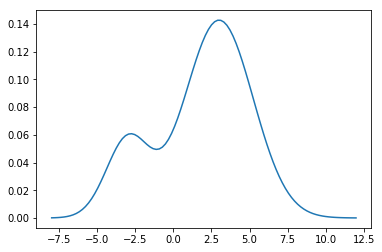

In [9]:
xs = np.linspace(-8., 12., 100)
plt.plot(xs, \
    .2 * scipy.stats.norm.pdf(xs, loc=-3., scale=np.sqrt(2.)) + \
    .8 * scipy.stats.norm.pdf(xs, loc=3., scale=np.sqrt(5.)));

Arguably the simplest way to approximate more or less any distribution, including bimodal, is by data points sampled from that distribution. We call those data points **particles**.

In [10]:
particles = []
for i in range(5000):
    if scipy.stats.uniform.rvs() <= .2:
        particles.append(scipy.stats.norm.rvs(loc=-3., scale=np.sqrt(2.)))
    else:
        particles.append(scipy.stats.norm.rvs(loc=3., scale=np.sqrt(5.)))

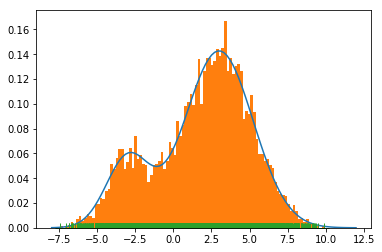

In [11]:
xs = np.linspace(-8., 12., 100)
plt.plot(xs, \
    .2 * scipy.stats.norm.pdf(xs, loc=-3., scale=np.sqrt(2.)) + \
    .8 * scipy.stats.norm.pdf(xs, loc=3., scale=np.sqrt(5.)))
plt.hist(particles, density=True, bins=100);
plt.plot(particles, [0 for p in particles], '+', markersize=10);

The more particles we have, the more closely can we approximate the target distribution. The approximate, empirical distribution is then given by the histogram. The particles don't have to be univariate, as in our example. They may be multivariate if we are approximating a multivariate distribution. Also, in our example the particles all have the same weight. More generally, we may consider weighted particles, whose weights are not all the same.

This gives rise to the family of algorithms known as **particle filtering** algorithms **[GSS93]**, **[Kit93]**. One of the most common of them is the **sequential importance resampling (SIR)** algorithm:

#### Sequential importance resampling (SIR)

1. **Initialisation step**: At time $t = 0$, draw $M$ i.i.d. samples (called **particles**) from the initial distribution $\tau_0$. Also, initialise $M$ normalised (to 1) weights to an identical value $\frac{1}{M}$. For $i = 1, 2, \ldots, M$, the samples will be denoted $\hat{\textbf{x}}_{0 \,|\, 0}^{(i)}$ and the normalised weights $\lambda_0^{(i)}$.
1. **Recursive step**: At time $t = 1, 2, 3, \ldots$, let $(\hat{\textbf{x}}_{t-1 \,|\, t-1}^{(i)})_{i=1,\ldots,M}$ be the particles generated at time $t - 1$.
 1. **Importance sampling**: For $i = 1, \ldots M$, sample $\hat{\mathbf{x}}_{t \,|\, t-1}^{(i)}$ from the Markov transition kernel $\tau_t(\cdot \,|\, \hat{\textbf{x}}_{t-1 \,|\, t-1}^{(i)})$. For $i = 1, \ldots, M$, use the observation density to compute the non-normalised weights
 $$\omega_t^{(i)} := \lambda_{t-1}^{(i)} \cdot p(\mathbf{y}_t \,|\, \hat{\mathbf{x}}_{t \,|\, t-1}^{(i)})$$
 and the values of the normalised weights before resampling ("br")
 $$^{\text{br}}\lambda_t^{(i)} := \frac{\omega_t^{(i)}}{\sum_{k=1}^M \omega_t^{(k)}}.$$
 1. **Resampling** (or **selection**): For $i = 1, \ldots, M$, use an appropriate resampling algorithm (such as **multinomial resampling** &mdash; see below) to sample $\mathbf{x}_{t \,|\, t}^{(i)}$ from the mixture
 $$\sum_{k=1}^M {^{\text{br}}} \lambda_t^{(k)} \delta(\mathbf{x}_t - \mathbf{x}_{t \,|\, t-1}^{(k)}),$$
 where $\delta(\cdot)$ denotes the Dirac delta generalised function, and set the normalised weights after resampling, $\lambda_t^{(i)}$, appropriately (for most common resampling algorithms this means $\lambda_t^{(i)} := \frac{1}{M}$). $\blacksquare$

In some sense, SIR resembles genetic algorithms. Based on the likelihoods $p(\mathbf{y}_t \,|\, \hat{\mathbf{x}}_{t \,|\, t-1}^{(i)})$, we increase the weights of the more "successful" particles, allowing them to "thrive" at the resampling step.

The resampling step was introduced to avoid the degeneration of the particles, with all the weight concentrating on a single point.

The most common resampling scheme is the so-called **multinomial resampling**:

#### Multinomial resampling

Notice that we are working with the *normalised* weights computed before reampling, ${^{\text{br}}}\lambda_t^{(1)}, {^{\text{br}}}\lambda_t^{(2)}, \ldots, {^{\text{br}}}\lambda_t^{(M)}$.

1. For $i = 1, 2, \ldots, M$, compute the cumulative sums
$${^{\text{br}}}\Lambda_t^{(i)} = \sum_{k=1}^i {^{\text{br}}}\lambda_t^{(k)},$$
so that, by construction, ${^{\text{br}}}\Lambda_t^{(M)} = 1$.
1. Generate $M$ random samples from $\mathcal{U}(0, 1)$, $u_1, u_2, \ldots, u_M$.
1. For each $i = 1, \ldots, M$, choose the particle $\hat{\mathbf{x}}_{t \,|\, t}^{(i)} = \hat{\mathbf{x}}_{t \,|\, t-1}^{(j)}$ with $j \in \{1, 2, \ldots, M - 1\}$ such that $u_i \in \left[{^{\text{br}}}\Lambda_t^{(j)}, {^{\text{br}}}\Lambda_t^{(j+1)}\right]$.

Thus we end up with $M$ new particles (**children**), $\mathbf{x}_{t \,|\, t}^{(1)}, \ldots, \mathbf{x}_{t \,|\, t}^{(M)}$ sampled from the existing set $\mathbf{x}_{t \,|\, t-1}^{(1)}, \ldots, \mathbf{x}_{t \,|\, t-1}^{(M)}$, so that some of the existing particles may disappear, while others may appear multiple times. For each $i = 1, \ldots, M$ the number of times $\mathbf{x}_{t \,|\, t-1}^{(i)}$ appears in the resampled set of particles is known as the particle's **replication factor**, $N_t^{(i)}$.

Set the normalised weights after resampling: $\lambda_t^{(i)} := \frac{1}{M}$.

We could view this algorithm as the sampling of the replication factors $N_t^{(1)}, \ldots N_t^{(M)}$ from the multinomial distribution with probabilities ${^{\text{br}}}\lambda_t^{(1)}, \ldots, {^{\text{br}}}\lambda_t^{(M)}$, respectively. Hence the name of the method. $\blacksquare$

## An application: stochastic volatility models

**Stochastic Volatility (SV)** models have been studied extensively in the literature, often as applications of **particle filtering** and **Markov chain Monte Carlo (MCMC)**.

In particular, Pitt, Malik, and Doucet apply the particle filter to the **stochastic volatility with leverage and jumps (SVLJ)** **[MP09]**, **[MP11a]**, **[MP11b]**, **[PMD14]**. The model has the general form of Taylor's **[Tay82]** with two modifications. For $t \in \mathbb{N}^0$, let $y_t$ denote the log-return on an asset and $x_t$ denote the log-variance of that return. Then
\begin{align}
y_t &= \epsilon_t e^{x_t/2} + J_t \varpi_t, \label{eq:svlj-log-return} \\
x_{t+1} &= \mu (1 - \phi) + \phi x_t + \sigma_v \eta_t, \label{eq:svlj-log-variance}
\end{align}
where $\mu$ is the mean log-variance, $\phi$ the persistence parameter, $\sigma_v$ the volatility of log-variance.

The first modification to Taylor's model is the introduction of correlation between $\epsilon_t$ and $\eta_t$:
\begin{equation*}
\left(
 \begin{array}{c}
   \epsilon_t \\
   \eta_t \\
 \end{array}
\right)
\sim \mathcal{N}(0, \Sigma),
\quad
\Sigma =
\left(
  \begin{array}{cc}
    1 & \rho \\
    \rho & 1 \\
  \end{array}
\right).
\end{equation*}

The correlation $\rho$ is the **leverage** parameter. In general, $\rho < 0$, due to the stylised fact known as the **leverage effect** **[Bla76]**.

The second change is the introduction of jumps. $J_t \in \{0, 1\}$ is a Bernoulli counter with intensity $p$ (thus $p$ is the jump intensity parameter), $\varpi_t \sim \mathcal{N}(0, \sigma_J^2)$ determines the jump size (thus $\sigma_J$ is the jump volatility parameter).

We obtain a **stochastic volatility with leverage (SVL)**, but no jumps, if we delete the $J_t \varpi_t$ term or, equivalently, set $p$ to zero. Taylor's original model is a special case of SVLJ with $p = 0$, $\rho = 0$.

### Particle filter for SVLJ

This, then, leads to the following adaptation of SIR, developed by Doucet, Malik, and Pitt, for this special case with nonadditive, correlated noises. The initial distribution of $x_0$ is taken to be $\mathcal{N}\left(0, \sigma_v^2 / (1 - \phi^2)\right)$.
1. **Initialisation step**: At time $t = 0$, draw $M$ i.i.d. particles from the initial distribution $\mathcal{N}(0, \sigma_v^2 / (1 - \phi^2))$. Also, initialise $M$ normalised (to 1) weights to an identical value of $\frac{1}{M}$. For $i = 1, 2, \ldots, M$, the samples will be denoted $\hat{x}^{(i)}_{0 \ | \  0}$ and the normalised weights $\lambda^{(i)}_0$.
1. **Recursive step**: At time $t \in \mathbb{N}^*$, let $(\hat{x}^{(i)}_{t-1 \ | \  t-1})_{i = 1, \ldots, M}$ be the particles generated at time $t - 1$.
    1. **Importance sampling**:
        - First,
            - For $i = 1, \ldots, M$, sample $\hat{\epsilon}^{(i)}_{t-1}$ from $p(\epsilon_{t-1} \ | \  x_{t-1} = \hat{x}^{(i)}_{t-1 \ | \  t-1}, y_{t-1})$. (If no $y_{t-1}$ is available, as at $t = 1$, sample from $p(\epsilon_{t-1} \ | \  x_{t-1} = \hat{x}^{(i)}_{t-1 \ | \  t-1})$).
            - For $i = 1, \ldots, M$, sample $\hat{x}^{(i)}_{t \ | \  t-1}$ from $p(x_t \ | \  x_{t-1} = \hat{x}^{(i)}_{t-1 \ | \  t-1}, y_{t-1}, \hat{\epsilon}^{(i)}_{t-1})$.
        - For $i = 1, \ldots, M$, compute the non-normalised weights
            \begin{equation}
            \omega^{(i)}_t := \lambda^{(i)}_{t-1} \cdot p_{\gamma_t}(y_{t} \ | \  \hat{x}^{(i)}_{t \ | \  t-1}),
            \end{equation}
            using the observation density
            \begin{gather*}
            p(y_t \ | \  \hat{x}^{(i)}_{t \ | \  t-1}, p, \sigma_J^2) = (1 - p) \left[ \left( 2\pi e^{\hat{x}^{(i)}_{t \ | \  t-1}} \right)^{-1/2} \exp\left(-y_t^2 / (2 e^{\hat{x}^{(i)}_{t \ | \  t-1}})\right) \right] + \\
            p \left[ \left( 2\pi ( e^{\hat{x}^{(i)}_{t \ | \  t-1}} + \sigma_J^2 ) \right)^{-1/2} \exp\left(-y_t^2 / (2 e^{\hat{x}^{(i)}_{t \ | \  t-1}} + 2\sigma_J^2)\right) \right],
            \end{gather*}
            and the values of the normalised weights before resampling (`br')
            \begin{equation*}
            {^\text{br}\lambda^{(i)}_t} := \frac{\omega^{(i)}_t}{\sum_{k=1}^M \omega^{(k)}_t}.
            \end{equation*}
    1. **Resampling** (or **selection**): For $i = 1, \ldots, M$, use an appropriate resampling algorithm (such as multinomial resampling) sample $\hat{x}^{(i)}_{t \ | \  t}$ from the mixture
        \begin{equation*}
        \sum_{k=1}^M {^\text{br}\lambda^{(k)}_t} \delta(x_t - \hat{x}^{(k)}_{t \ | \  t-1}),
        \end{equation*}
        where $\delta(\cdot)$ denotes the Dirac delta generalised function, and set the normalised weights after resampling, $\lambda^{(i)}_t$, according to the resampling algorithm.

### Calibrating stochastic filters: the frequentist approach

We have seen in the example of the stochastic volatility model with leverage and jumps (SVLJ) that the state-space model may be parameterised by a parameter vector, $\mathbf{\theta} \in \mathbb{R}^{d_{\theta}}$, $d_{\theta} \in \mathbb{N}^*$. In that particular case,
\begin{equation*}
\mathbf{\theta} = \left(
           \begin{array}{c}
             \mu \\
             \phi \\
             \sigma_{\eta}^2 \\
             \rho \\
             \sigma_J^2 \\
             p \\
           \end{array}
         \right).
\end{equation*}

We may not know the true value of this parameter. How do we estimate it? In other words, how do we **calibrate** the model, given a time series of either historical or generated observations, $\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_T$, $T \in \mathbb{T} = \mathbb{N}^*$.

The frequentist approach relies on the (joint) probability density function of the observations, which depends on the parameters, $p(\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_T \,|\, \mathbf{\theta})$. We can regard this as a function of $\mathbf{\theta}$ with $\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_T$ fixed, $p(\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_T \,|\, \mathbf{\theta}) =: \mathcal{L}(\mathbf{\theta})$ &mdash; the **likelihood function**.

It is sometimes referred to as **marginal** likelihood, since the hidden states, $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_T$, are margined out. We seek a **maximum likelihood estimator (MLE)**, $\hat{\mathbf{\theta}}_{ML}$, the value of $\mathbf{\theta}$ that maximises the likelihood function.

Each evaluation of the objective function, $\mathcal{L}(\mathbf{\theta})$, constitutes a run the stochastic filter over the observations $\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_T$. By the chain rule (i), and since we are dealing with a Markov chain (ii),
\begin{equation*}
p(\mathbf{y}_1, \ldots, \mathbf{y}_T) \overset{\text{(i)}}{=} \prod_{t=1}^T p(\mathbf{y}_t \ | \  \mathbf{y}_0, \ldots, \mathbf{y}_{t-1}) \overset{\text{(ii)}}{=} \prod_{t=1}^T \int p(\mathbf{y}_t \ | \  \mathbf{x}_t) p(\mathbf{x}_t \ | \  \mathbf{y}_0, \ldots, \mathbf{y}_{t-1}) \, d\mathbf{x}_t.
\end{equation*}
Here we have omitted the dependence of all the probability densities on $\mathbf{\theta}$, e.g. we should have really written $p(\mathbf{y}_1, \ldots, \mathbf{y}_T; \mathbf{\theta})$.

For the particle filter, we can estimate the log-likelihood function from the non-normalised weights:
\begin{equation*}
p(\mathbf{y}_1, \ldots, \mathbf{y}_T) = \prod_{t=1}^T \int p(\mathbf{y}_t \ | \  \mathbf{x}_t) p(\mathbf{x}_t \ | \  \mathbf{y}_0, \ldots, \mathbf{y}_{t-1}) \, d\mathbf{x}_t \approx \prod_{t=1}^T \left( \frac{1}{M} \sum_{k=1}^M \omega^{(k)}_t \right),
\end{equation*}
whence
\begin{equation}
\ln(\mathcal{L}(\mathbf{\theta})) = \ln \left\{ \prod_{t=1}^T \left( \frac{1}{M} \sum_{k=1}^M \omega^{(k)}_t \right) \right\} = \sum_{t=1}^T \ln\left( \frac{1}{M} \sum_{k=1}^M \omega^{(k)}_t \right).
\label{eq:particle-filter-log-likelihood}
\end{equation}

This was first proposed by Kitagawa **[Kit93]**, **[Kit96]** for the purposes of approximating $\hat{\mathbf{\theta}}_{ML}$.

In most practical applications one needs to resort to numerical methods, perhaps quasi-Newton methods, such as **Broyden-Fletcher-Goldfarb-Shanno (BFGS)** **[GMW82]**, to find $\hat{\mathbf{\theta}}_{ML}$.

Malik, Pitt, and Doucet **[PMD14]** point out the practical difficulties which result when using the above as an objective function in an optimiser. In the resampling (or selection) step of the particle filter, we are sampling from a discontinuous empirical distribution function. Therefore $\ln(\mathcal{L}(\mathbf{\theta}))$ will not be continuous as a function of $\mathbf{\theta}$. To remedy this, they rely on an alternative, continuous, resampling procedure described in. A quasi-Newton method is then used to find $\hat{\mathbf{\theta}}_{ML}$ for the parameters $\mathbf{\theta} = (\mu, \phi, \sigma_v^2, \rho, p, \sigma_J^2)^{\intercal}$ of the SVLJ model.

Kalman filters can also be calibrated using a similar maximum likelihood approach.

### Calibrating stochastic filters: the Bayesian approach

Let us briefly discuss how filtering methods relate to **Markov chain Monte Carlo methods (MCMC)** --- a vast subject in its own right, therefore our discussion will be cursory at best. The technique takes its origin from **[MRRT53]**.

Proceeding along the lines of **[KSC98]**, Meyer and Yu **[MY00]**, **[Yu05]** demonstrate how MCMC techniques can be used to estimate the parameters of the SVL model. They calibrate the parameters to the time series of observations of daily mean-adjusted log-returns, $y_1, \ldots, y_T$. They obtain the joint prior density
\begin{equation*}
p(\mathbf{\theta}, x_0, \ldots, x_T) = p(\mathbf{\theta}) p(x_0 \ | \  \mathbf{\theta}) \prod_{t=1}^T p(x_t \ | \  x_{t-1}, \mathbf{\theta})
\end{equation*}
by successive conditioning. Here $\mathbf{\theta} = (\mu, \phi, \sigma_v^2, \rho)^{\intercal}$ is, as before, the vector of the model's parameters. They assume prior independence of the parameters and choose the same priors as in **[KSC98]** for $\mu$, $\phi$, and $\sigma_v^2$, and a uniform prior for $\rho$. The observation model and the conditional independence assumption give the likelihood
\begin{equation*}
p(y_1, \ldots, y_T \ | \  \mathbf{\theta}, x_0, \ldots, x_T) = \prod_{t=1}^T p(y_t \ | \  x_t),
\end{equation*}
and the joint posterior distribution of the **unobservables** (the parameters $\mathbf{\theta}$ and the hidden states $x_0, \ldots, x_T$; in the Bayesian perspective these are treated identically and estimated in a similar manner) follows from Bayes's theorem; for the SVL model, this posterior satisfies
\begin{equation*}
p(\mathbf{\theta}, x_0, \ldots, x_T \ | \  y_1, \ldots, y_T) \propto p(\mu) p(\phi) p(\sigma_v^2) p(\rho) \prod_{t=1}^T p(x_{t+1} \ | \  x_t, \mu, \phi, \sigma_v^2) \prod_{t=1}^T p(y_t \ | \  x_{t+1}, x_t, \mu, \phi, \sigma_v^2, \rho),
\end{equation*}
where $p(\mu)$, $p(\phi)$, $p(\sigma_v^2)$, $p(\rho)$ are the appropriately chosen priors,
\begin{align*}
x_{t+1} \ | \  x_t, \mu, \phi, \sigma_v^2 &\sim \mathcal{N}\left(\mu (1 - \phi) + \phi x_t, \sigma_v^2\right), \\
y_t \ | \  x_{t+1}, x_t, \mu, \phi, \sigma_v^2, \rho &\sim \mathcal{N}\left(\frac{\rho}{\sigma_v} e^{x_t/2} \left( x_{t+1} - \mu (1 - \phi) - \phi x_t \right), e^{x_t} (1 - \rho^2)\right).
\end{align*}

Meyer and Yu use the software package \textsf{BUGS}\footnote{An acronym for Bayesian inference Using Gibbs Sampling.}~\cite{spiegelhalter-1996, lunn-2000} to represent the resulting Bayesian model as a \emph{directed acyclic graph (DAG)}, where the nodes are either constants (denoted by rectangles), stochastic nodes (variables that are given a distribution, denoted by ellipses), or deterministic nodes (logical functions of other nodes); the arrows either indicate stochastic dependence (solid arrows) or logical functions (hollow arrows). This graph helps visualise the conditional (in)dependence assumptions and is used by \textsf{BUGS} to construct full univariate conditional posterior distributions for all unobservables. It then uses Markov chain Monte Carlo algorithms to sample from these distributions.

The algorithm based on the original work~\cite{metropolis-1953} is now known as the \emph{Metropolis algorithm}. It has been generalised by Hastings~(1930--2016) to obtain the \emph{Metropolis-Hastings algorithm}~\cite{hastings-1970} and further by Green to obtain what is known as the \emph{Metropolis-Hastings-Green algorithm}~\cite{green-1995}. A popular algorithm based on a special case of the Metropolis-Hastings algorithm, known as the \emph{Gibbs sampler}, was developed by the brothers Geman \cite{geman-1984} and, independently, Tanner and Wong \cite{tanner-1987}\footnote{Sometimes the Gibbs sampler is referred to as \emph{data augmentation} following this paper.}. It was further popularised by Gelfand and Smith~\cite{gelfand-1990}. Gibbs sampling and related algorithms \cite{gilks-1992, ritter-1992} are used by \textsf{BUGS} to sample from the univariate conditional posterior distributions for all unobservables.

As a result we perform Bayesian estimation --- obtain estimates of the \emph{distributions} of the parameters $\mu$, $\phi$, $\sigma_v^2$, $\rho$ --- rather than frequentist estimation, where a single value of the parameters vector, which maximises the likelihood, $\hat{\mathbf{\theta}}_{ML}$, is produced, as we saw in Section~\ref{sec:filtering_parameter-estimation}. Stochastic filtering, sometimes in combination with MCMC, can be used for both frequentist and Bayesian parameter estimation~\cite{chen-2003}. Filtering methods that update estimates of the parameters online, while processing observations in real-time, are referred to as \emph{adaptive filtering} (see~\cite{sayed-2008, reyvega-2013, crisan-2013-1, naesseth-2015} and references therein).

In [26]:
df1 = pd.read_csv('../../../data/dataset-1.csv')
y1 = df1['daily_log_return'].values

In [27]:
df2 = pd.read_csv('../../../data/dataset-2.csv')
y2 = df2['daily_log_return'].values

To use Dataset 1:

In [28]:
# log_returns = y1

To use Dataset 2:

In [29]:
log_returns = y2

#### Implementation of the stochastic volatility model with leverage in PyMC3

In [30]:
class StochasticVolatilityProcess(pm.distributions.distribution.Continuous):
    def __init__(self, mu=None, phi=None, sigmav=None,
                 *args, **kwargs):
        super(StochasticVolatilityProcess, self).__init__(*args, **kwargs)
        self.alpha = pm.Deterministic('alpha', (1. - phi) * mu)
        self.phi = phi
        self.sigmav = sigmav
        self.init = pm.Normal.dist(mu=mu, sd=sigmav)
        self.mean = tt.as_tensor_variable(0.)

    def logp(self, x):
        alpha = self.alpha
        phi = self.phi
        sigmav = self.sigmav
        init = self.init

        x_im1 = x[:-1]
        x_i = x[1:]

        innov_like = pm.Normal.dist(mu=alpha + phi * x_im1, sd=sigmav).logp(x_i)
        return init.logp(x[0]) + tt.sum(innov_like)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        mu = dist.mu
        sd = dist.sd
        name = r'\text{%s}' % name
        return r'${} \sim \text{{StochasticVolatilityProcess}}(\mathit{{mu}}={},~\mathit{{sd}}={})$'.format(name,
                get_variable_name(mu), get_variable_name(sd))

In [31]:
def make_stochastic_volatility_model(model, log_returns):
    mu = pm.Normal(name='mu', mu=0., sd=np.sqrt(25.))
    phistar = pm.Beta(name='phistar', alpha=20., beta=1.5)
    recsigmav2 = pm.Gamma(name='recsigmav2', alpha=2.5, beta=.25)
    beta = pm.math.exp(pm.Deterministic('beta', .5 * mu))
    phi = pm.Deterministic('phi', 2. * phistar - 1.)
    sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
    x = StochasticVolatilityProcess('x', mu, phi, sigmav, shape=len(log_returns) + 1)
    y = pm.Normal(name='y', mu=0., sd=pm.math.sqrt(pm.math.exp(x[1:])), observed=log_returns)

In [32]:
def make_stochastic_volatility_model_with_leverage(model, log_returns):
    mu = pm.Normal(name='mu', mu=0., sd=np.sqrt(25.))
    phistar = pm.Beta(name='phistar', alpha=20., beta=1.5)
    recsigmav2 = pm.Gamma(name='recsigmav2', alpha=2.5, beta=.25)
    beta = pm.math.exp(pm.Deterministic('beta', .5 * mu))
    phi = pm.Deterministic('phi', 2. * phistar - 1.)
    sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
    rho = pm.Uniform(name='rho', lower=-1., upper=1.)
    x = StochasticVolatilityProcess('x', mu, phi, sigmav, shape=len(log_returns) + 2)
    y = pm.Normal(name='y',
                  mu=rho / sigmav * pm.math.exp(.5 * x[1:-1]) * (x[2:] - (1. - phi) * mu - phi * x[1:-1]),
                  sd=pm.math.sqrt(pm.math.exp(x[1:-1]) * (1 - rho * rho)),
                  observed=log_returns)

#### Playing with the model

Let's apply the stochastic volatility model, no leverage:

Making model...
Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, recsigmav2, phistar, mu]
100%|██████████| 2500/2500 [06:52<00:00,  5.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Producing trace plot...


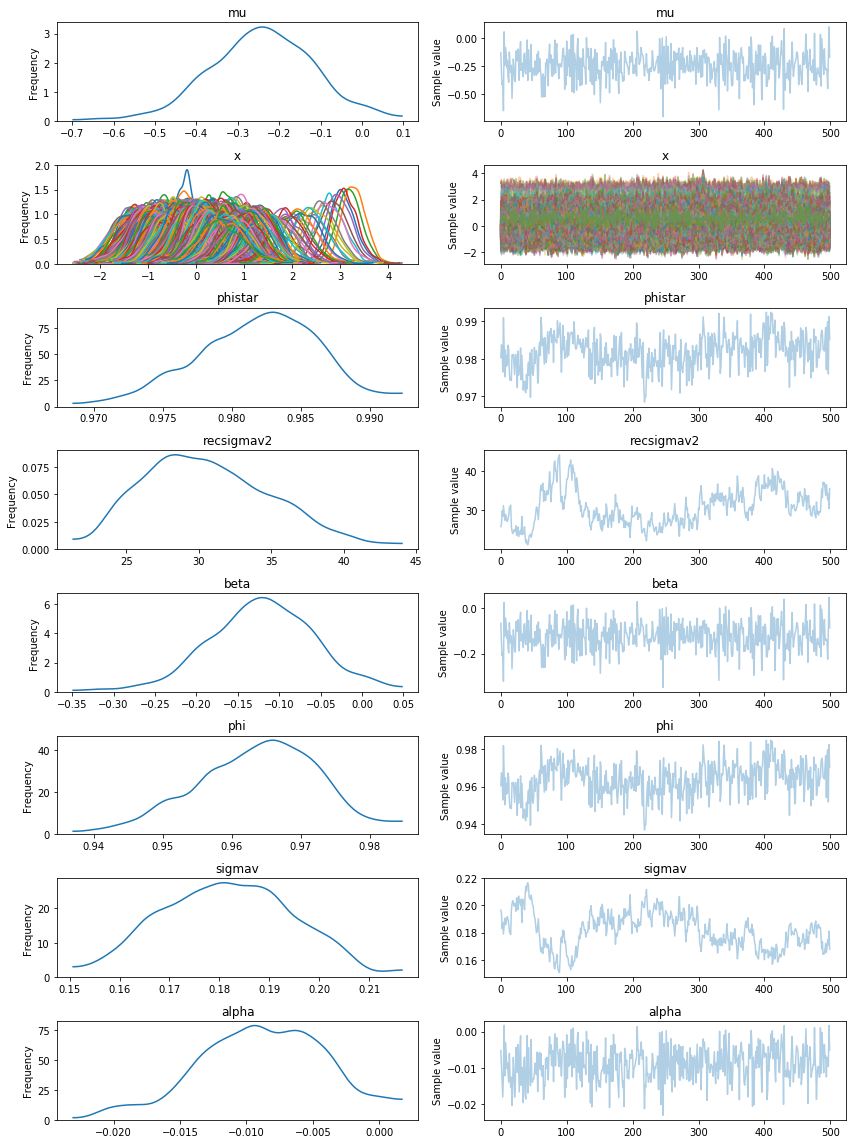

In [33]:
with pm.Model() as model:
    print('Making model...')
    make_stochastic_volatility_model(model, log_returns)
    print('Sampling...')
    trace = pm.sample(tune=1000, draws=10000, nuts_kwargs=dict(target_accept=.9), chains=1)
    print('Producing trace plot...')
    pm.traceplot(trace);

Let's apply the stochastic volatility model with leverage:

In [34]:
with pm.Model() as model:
    print('Making model...')
    make_stochastic_volatility_model_with_leverage(model, log_returns)
    print('Sampling...')
    trace = pm.sample(tune=1000, draws=10000, nuts_kwargs=dict(target_accept=.9), chains=1)
    print('Producing trace plot...')
    pm.traceplot(trace);

Making model...
Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, rho, recsigmav2, phistar, mu]
  4%|▎         | 399/11000 [01:49<53:38,  3.29it/s]  C:\Programs\Win64\Anaconda\V2019.03_Python-3.7\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


Producing trace plot...


C:\Programs\Win64\Anaconda\V2019.03_Python-3.7\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


## Further reading

For more information on filtering we refer the reader to **[Hay01]**, **[May79]**, **[Sim06]**, **[BC09]**, **[Sar13]**.

For more information on MCMC, the reader may wish to consult **[Gey11]**.

## Bibliography

**[BC09]** Alan Bain and Dan Crisan. *Fundamentals of Stochastic Filtering (Stochastic Modelling and Applied Probability Book 60).* Springer, 2009.

**[BD87]** Peter J. Brockwell and Richard A. Davis. *Time Series: Theory and Methods.* Springer-Verlag, 1987.

**[Bil16]** Paul Bilokon. Bayesian methods for solving estimation and forecasting problems in the high-frequency trading environment. MSc thesis, University of Oxford, 2016.

**[BJR94]** George E. P. Box, Gwilym M. Jenkins, and Gregory C. Reinsel. *Time Series Analysis.* Prentice-Hall, 1994.

**[Bla76]** Fisher Black, 1976. Studies of Stock Price Volatility Changes. *Proceedings of the Business and Economics Section of the American Statistical Association*, 177-181.

**[dJP00]** Piet de Jong and Jeremy Penzer. The ARIMA model in state space form. Research Report 40, Department of Statistics, London School of Economics, Houghton Street, London, WC2A 2AE, UK, August 2000. http://www.lse.ac.uk/statistics/documents/researchreport40.pdf.

**[DK00]** James Durbin and Siem Jan Koopman. Time series analysis of non-Gaussian observations based on state space models from both classical and Bayesian perspectives (with discussion). *Journal of the Royal Statistical Society, Series B*, 62:3-56, 2000.

**[Gey11]** Charles J. Geyer. *Handbook of Markov Chain Monte Carlo*, chapter Introduction to Markov Chain Monte Carlo, pages 3-49. Handbooks of Modern Statistical Methods. CRC Press, 2011.

**[GG84]** Stuart Jay Geman and Donald Geman. Stochastic relaxation, Gibbs distributions, and the Bayesian restoration of images. *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 6:721-741, 1984.

**[GMW82]** Philip E. Gill, Walter Murray and Margaret H. Wright. *Practical Optimization*. Academic Press, 1982.

**[GSS93]** N.J. Gordon, D.J. Salmond, and A.F.M. Smith. Novel approach to nonlinear/non-Gaussian Bayesian state estimation. In *IEE Proceedings F (Radar and Signal Processing)*, 1993.

**[Ham94]** James Douglas Hamilton. *Time Series Analysis.* Princeton University Press, 1994.

**[Har89]** Andrew C. Harvey. *Forecasting, structural time series models and the Kalman filter.* Cambridge
University Press, 1989.

**[Hay01]** Simon Haykin, editor. *Kalman Filtering and Neural Networks.* John Wiley and Sons, Inc., 2001.

**[HRS94]** Andrew C. Harvey, Esther Ruiz, and Neil Shephard. Multivariate stochastic variance models. *Review of Economic Studies*, 61:247-264, 1994.

**[Kal60]** Rudolf Emil Kalman. A new approach to linear filtering and prediction problems. *Transactions of the ASME - Journal of Basic Engineering, Series D*, 82:35-45, 1960.

**[Kit93]** Genshiro Kitagawa. A Monte Carlo filtering and smoothing method for non-Gaussian nonlinear state space models. In *Proceedings of the 2nd U.S.-Japan Joint Seminar on Statistical Time Series Analysis*, pages 110-131, 1993.

**[Kit96]** Genshiro Kitagawa. Monte Carlo filter and smoother for non-Gaussian nonlinear state space models. *Journal of Computational and Graphical Statistics*, 5(1):1-25, 1996.

**[KSC98]** Sangjoon Kim, Neil Shephard, and Siddhartha Chib. Stochastic volatility: Likelihood inference and comparison with ARCH models. *The Review of Economic Studies*, 65(3):361-393, July 1998.

**[May79]** Peter S. Maybeck. *Stochastic Models, Estimation and Control, Volume 1.* Academic Press, 1979.

**[MP09]** Sheheryar Malik and Michael K. Pitt. Modelling stochastic volatility with leverage and jumps: A simulated maximum likelihood approach via particle filtering. Warwick Economic Research Papers 897, The University of Warwick, Department of Economics, Coventry CV4 7AL, April 2009.

**[MP11a]** Sheheryar Malik and Michael K. Pitt. Modelling stochastic volatility with leverage and jumps: A simulated maximum likelihood approach via particle filtering. document de travail 318, Banque de France Eurosysteme, February 2011.

**[MP11b]** Sheheryar Malik and Michael K. Pitt. Particle filters for continuous likelihood evaluation and maximisation. *Journal of Econometrics*, 165:190–209, 2011.

**[MRRT53]** Nicholas Metropolis, Arianna W. Rosenbluth, Marshall N. Rosenbluth, Augusta H. Teller, and Edward Teller. Equation of state calculations by fast computing machines. *Journal of Chemical Physics*, 21, 1953.

**[MY00]** Renate Meyer and Jun Yu. BUGS for a Bayesian analysis of stochastic volatility models. *Econometrics Journal*, 3:198-215, 2000.

**[Pea80]** J. G. Pearlman. An algorithm for the exact likelihood of a high-order autoregressive-moving average
process. *Biometrika*, 67(1):232–233, 1980.

**[PMD14]** Michael K. Pitt, Sheheryar Malik, and Adnaud Doucet. Simulated likelhood inference for stochastic volatility models using continuous particle filtering. *Annals of the Institute of Statistical Mathematics*, 66:527–552, 2014.

**[Sar13]** Simo Sarkka. *Bayesian filtering and smoothing (Institute of Mathematical Statistics Textbooks).* Cambridge University Press, 2013.

**[Sim06]** Dan Simon. *Optimal State Estimation: Kalman, H-infinity, and Nonlinear approaches.* Wiley, 2006.

**[SP97]** Neil Shephard and Michael K. Pitt. Likelihood analysis of non-Gaussian measurement time series. *Biometrika*, 84:653-667, 1997.

**[Tay82]** Stephen J. Taylor. *Time Series Analysis: Theory and Practice*, chapter Financial returns modelled by
the product of two stochastic processes, a study of daily sugar prices, pages 203–226. North-Holland,
1982.

**[Yu05]** Jun Yu. On leverage in a statistical volatility model. *Journal of Econometrics*, 127:165-178, 2005.

**[ZW06]** Eric Zivot and Jiahui Wang. *Modeling Financial Time Series with S-PLUS.* Springer, 2006.